# Visualize GOES-16 Data from S3

#### This code retrieves a GOES-16 NetCDF file from the S3 bucket and visualize it. GOES makes 4 measurements in each hour, and only the first one is retrieved here. 

In [9]:
import xarray as xr
import requests
import netCDF4
import boto3
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt

In [10]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadF'
year = 2019
day_of_year = 79
hour = 14
band = 3

In [11]:
# Initialize s3 client. 
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [12]:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [13]:
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M3C{band:02.0f}'
                  )


key = [key for key in keys][0] # selecting the first measurement taken within the hour

In [14]:
resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')

In [15]:
file_name = key.split('/')[-1].split('.')[0]
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)

In [20]:
print(DS)

<xarray.Dataset>
Dimensions:                                 (y: 10848, x: 10848,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             band: 1, num_star_looks: 24)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float64 0.1519 ... -0.1519
  * x                                       (x) float64 -0.1519 ... 0.1519
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_id                                 (band) int8 ...
    band_wavelength                         (band) float32 ...
    t_star_look                             (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look               (num_star_looks) float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
        

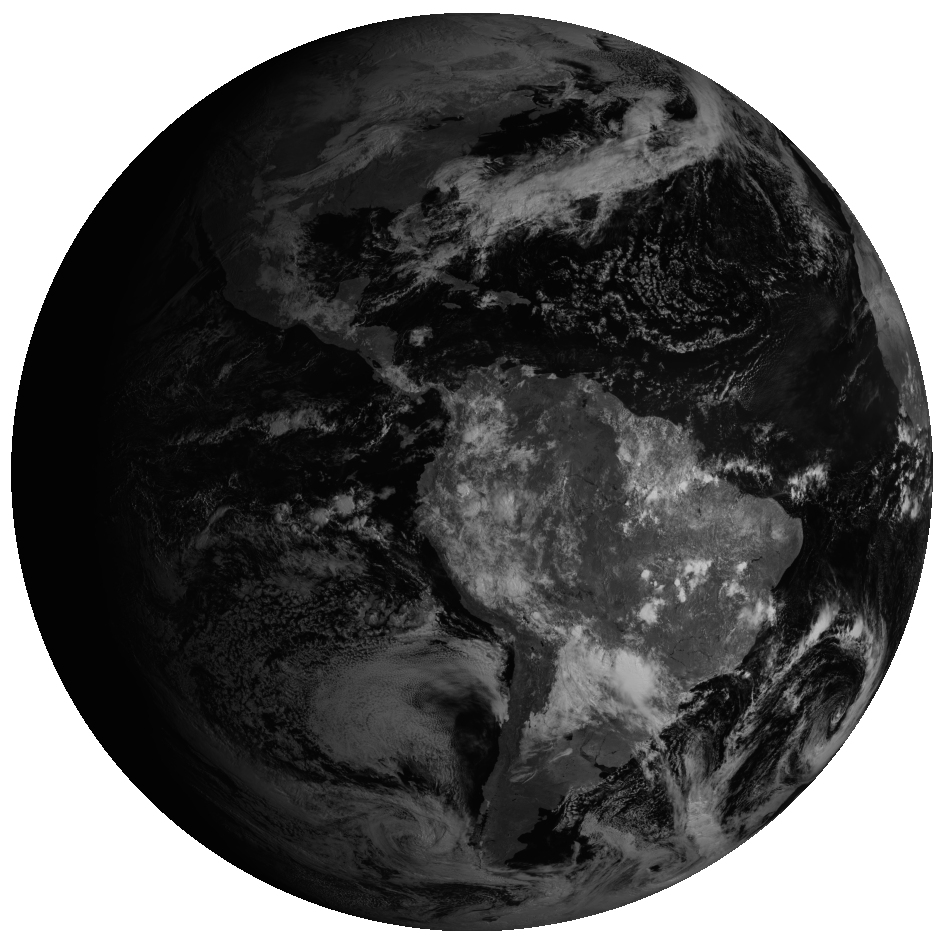

In [22]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(DS.Rad, cmap='gray')
plt.axis('off')
plt.savefig(f'{file_name}.png', dpi=300, facecolor='w', edgecolor='w')